# TML Assignment 2 (Policy Gradient Methods)

**Samartha S M**

**(2018101094)**


All the components of this assignment are attempted. Related analysis is written after each training method on each environment given.

# Import Libraries

In [1]:
# Import libraries
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical, Normal

from tqdm.notebook import tqdm

# Policy Gradient Model

In [2]:
class PolicyGradientAgent(nn.Module):
    '''
    Models Policy Gradient based agent. Takes in state features and outputs 
    actions probabilities (discrete action space) and distribution parameters
    (continuous action space) (here gaussian is used)

    Input
    -----
    Sf: (int) Dimension of state features
    Af: (int) Dimension of action space
    cont: (boolean) Continuous / Discrete action space
    '''

    # Initialization method
    def __init__(self, Sf, Af, cont):
        super(PolicyGradientAgent, self).__init__()
        self.hidden = nn.Linear(in_features=Sf, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=Af)
        self.continuous = cont

    # Forward step method
    def forward(self, state_feature):
        out = self.hidden(state_feature)
        out = F.relu(out)
        out = self.out(out)

        if not self.continuous:
            policy = F.softmax(out, dim=0)
            return policy

        return out

# Episode Generator and Training Code

In [3]:
def get_episode(env, policy, cont):
    '''
    Function to get an episode of simulation given environemt and policy network

    Input
    -----
    env:    (object)  Environment
    policy: (object)  Policy network
    cont:   (boolean) Continuous/discrete action space

    Output
    ------
    states:    (tensor) Tensor of states visited over time
    actions:   (tensor) Tensor of actions taken over time
    rewards:   (tensor) Tensor of rewards obtained over time
    log_probs: (list)   List of log probabilities of actions taken over time
    '''
    
    states = []
    actions = []
    rewards = []
    log_probs = []

    state = env.reset()
    while True:
        state_t = torch.Tensor(state)
        state_t.requires_grad = True

        if not cont:
            probs = policy(state_t)
            sampler = Categorical(probs)
            action = sampler.sample()
            next_state, reward, done, info = env.step(action.item())

        else:
            params = policy(state_t)
            sampler = Normal(params[0], torch.exp(params[1]))
            action = sampler.sample()
            next_state, reward, done, info = env.step([action.item()])

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        log_probs.append(sampler.log_prob(action))

        state = next_state

        if done:
            break

    return torch.Tensor(states), torch.Tensor(actions), torch.Tensor(rewards), log_probs

In [4]:
def discounted_rewards(rewards, discount):
    '''
    Function to compute discounted rewards/returns

    Input
    -----
    rewards:    (list)  List of rewards over time in an episode
    discount:   (float) Discount factor

    Output
    ------
    G:          (list) Discounted rewards
    '''
    
    G = []
    tot_r = 0

    for r in reversed(rewards):
        tot_r = tot_r * discount + r
        G.append(tot_r)

    G = torch.Tensor(np.array(list(reversed(G))))

    return G

In [5]:
def train(env, policy, epochs, gamma, lr, cont, base):
    '''
    Function to train the policy network using policy gradient methods

    Input
    -----
    env:    (object)  Input environment on which the model will be trained
    policy: (object)  Policy network which will be trained
    epochs: (int)     Number of epochs for training
    gamma:  (float)   Discount factor
    lr:     (float)   Learning rate
    cont:   (boolean) Continuous/discrete action space
    base:   (boolean) With baseline / without baseline

    Output
    ------
    scores: (list)  List of rewards in each epoch
    '''
    
    opt = torch.optim.Adam(params=policy.parameters(), lr=lr)
    scores = []

    for ep in tqdm(range(epochs)):
        S, A, R, Lp = get_episode(env, policy, cont)
        G = discounted_rewards(R, gamma)
        scores.append(torch.sum(R))
        
        if base:
            baseline = G.mean()
        else:
            baseline = 0

        loss = 0
        for lp, dr in zip(Lp, G):
            loss += -lp * (dr - baseline)

        opt.zero_grad()
        loss.backward()
        opt.step()

        print("Epoch: %d \tLoss: %.3f \tScore: %.3f" % (ep+1, loss.item(), scores[-1]))

    return scores

# Initialize environment and train the model

### Vanilla Policy Gradient (Discrete Mountain Car)

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Epoch: 1 	Loss: -2037.481 	Score: -200.000
Epoch: 2 	Loss: -2071.944 	Score: -200.000
Epoch: 3 	Loss: -2070.357 	Score: -200.000
Epoch: 4 	Loss: -2101.581 	Score: -200.000
Epoch: 5 	Loss: -2064.115 	Score: -200.000
Epoch: 6 	Loss: -2057.127 	Score: -200.000
Epoch: 7 	Loss: -2063.897 	Score: -200.000
Epoch: 8 	Loss: -1972.270 	Score: -200.000
Epoch: 9 	Loss: -2037.645 	Score: -200.000
Epoch: 10 	Loss: -2013.951 	Score: -200.000
Epoch: 11 	Loss: -2016.013 	Score: -200.000
Epoch: 12 	Loss: -1969.941 	Score: -200.000
Epoch: 13 	Loss: -2067.280 	Score: -200.000
Epoch: 14 	Loss: -2013.556 	Score: -200.000
Epoch: 15 	Loss: -2049.125 	Score: -200.000
Epoch: 16 	Loss: -2075.776 	Score: -200.000
Epoch: 17 	Loss: -2033.636 	Score: -200.000
Epoch: 18 	Loss: -2113.181 	Score: -200.000
Epoch: 19 	Loss: -2064.728 	Score: -200.000
Epoch: 20 	Loss: -2033.185 	Score: -200.000
Epoch: 21 	Loss: -2030.905 	Score: -200.000
Epoch: 22 	Loss: -2093.260 	Score: -200.000
Epoch: 23 	Loss: -2021.216 	Score: -200.0

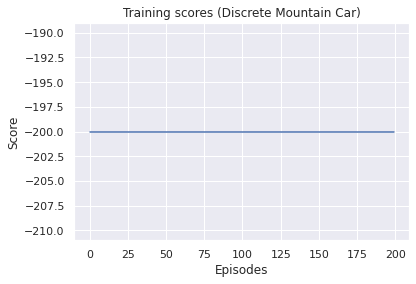


Variance of rewards: 0.0 



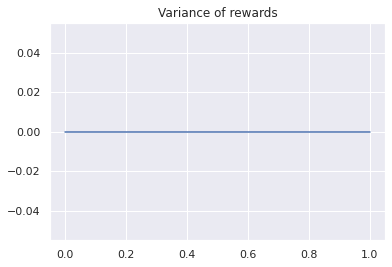

In [ ]:
env = gym.make('MountainCar-v0')
Sf = env.observation_space.shape[0]
Af = env.action_space.n
DISCOUNT = 0.9
EPOCHS = 200
LR = 0.001

policy_agent = PolicyGradientAgent(Sf, Af, cont=False)
scores = train(env, policy_agent, EPOCHS, DISCOUNT, LR, cont=False, base=False)

print()
sns.set()

plt.plot(scores)
plt.title("Training scores (Discrete Mountain Car)")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.show()

print("\nVariance of rewards:", np.var(scores), "\n")
plt.plot([0, 1], np.ones(2) * np.var(scores))
plt.title("Variance of rewards")
plt.show()

We see that the score in all epochs of the training phase is same (-200). This shows that the optimal policy is not being learnt. This also could be a resultant of an inefficient environment. As policy gradient is mainly designed to use neural networks and operate on real numbers, it might work bad on discrete action space environments. This environment is an example of that. As the score/reward is same across all epochs, the variance of the rewards is 0.

### Vanilla Policy Gradient (Continuous Mountain Car)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 	Loss: -1942.093 	Score: -122.418
Epoch: 2 	Loss: -1920.772 	Score: -121.366
Epoch: 3 	Loss: -1595.932 	Score: -104.575
Epoch: 4 	Loss: -1632.244 	Score: -106.772
Epoch: 5 	Loss: -1655.801 	Score: -108.249
Epoch: 6 	Loss: -1480.092 	Score: -99.956
Epoch: 7 	Loss: -1514.019 	Score: -101.250
Epoch: 8 	Loss: -1476.828 	Score: -99.035
Epoch: 9 	Loss: -1384.724 	Score: -94.823
Epoch: 10 	Loss: -1307.024 	Score: -90.163
Epoch: 11 	Loss: -1384.002 	Score: -93.083
Epoch: 12 	Loss: -1321.693 	Score: -90.732
Epoch: 13 	Loss: -1193.587 	Score: -85.136
Epoch: 14 	Loss: -1011.459 	Score: -74.644
Epoch: 15 	Loss: -1221.623 	Score: -85.189
Epoch: 16 	Loss: -1067.976 	Score: -77.819
Epoch: 17 	Loss: -1082.557 	Score: -79.211
Epoch: 18 	Loss: -1102.801 	Score: -79.397
Epoch: 19 	Loss: -873.799 	Score: -67.267
Epoch: 20 	Loss: -907.570 	Score: -68.746
Epoch: 21 	Loss: -850.620 	Score: -65.839
Epoch: 22 	Loss: -839.161 	Score: -65.126
Epoch: 23 	Loss: -796.078 	Score: -62.354
Epoch: 24 	Loss: -8

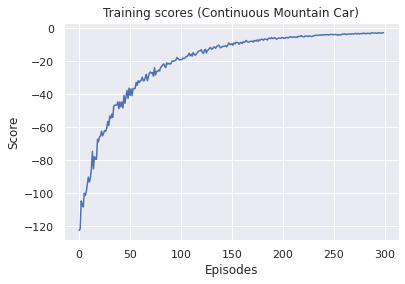


Variance of rewards: 605.4922 



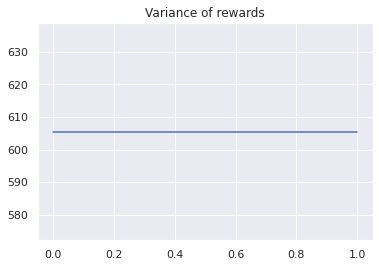

In [ ]:
env = gym.make('MountainCarContinuous-v0')
Sf = env.observation_space.shape[0]
Af = 2
DISCOUNT = 0.9
EPOCHS = 300
LR = 0.001

policy_agent = PolicyGradientAgent(Sf, Af, cont=True)
scores = train(env, policy_agent, EPOCHS, DISCOUNT, LR, cont=True, base=False)

print()
sns.set()

plt.plot(scores)
plt.title("Training scores (Continuous Mountain Car)")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.show()

print("\nVariance of rewards:", np.var(scores), "\n")
plt.plot([0, 1], np.ones(2) * np.var(scores))
plt.title("Variance of rewards")
plt.show()

Here we see the working of policy gradient approach efficiently. The rewards vs epochs plot shows the improving nature of learnt policy. We see that in the initial epochs, the reward obtained through simulations performed is around -120. By epochs 300, the policy seems to be converging with reward of around -2. Giving it even more iterations can bring it closer to -1 reward. The variance however seems to be reasonable, not too large neither too small. The variance of 605.5 could be because of normalized policy outputs while sampling. I have used Normal distribution to sample the action, which could have resulted in smaller variance. Overall, the learning efficacy can be seen in this problem.

### Vanilla Policy Gradient (Discrete Acrobot)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	Loss: -2455.584 	Score: -239.000
Epoch: 2 	Loss: -3723.265 	Score: -358.000
Epoch: 3 	Loss: -3545.667 	Score: -360.000
Epoch: 4 	Loss: -3352.220 	Score: -332.000
Epoch: 5 	Loss: -3123.209 	Score: -305.000
Epoch: 6 	Loss: -3766.969 	Score: -368.000
Epoch: 7 	Loss: -4772.696 	Score: -462.000
Epoch: 8 	Loss: -3180.735 	Score: -313.000
Epoch: 9 	Loss: -2436.147 	Score: -241.000
Epoch: 10 	Loss: -4220.348 	Score: -416.000
Epoch: 11 	Loss: -3062.759 	Score: -292.000
Epoch: 12 	Loss: -2768.006 	Score: -281.000
Epoch: 13 	Loss: -3849.059 	Score: -373.000
Epoch: 14 	Loss: -4839.712 	Score: -460.000
Epoch: 15 	Loss: -5190.302 	Score: -495.000
Epoch: 16 	Loss: -3301.077 	Score: -325.000
Epoch: 17 	Loss: -5160.069 	Score: -500.000
Epoch: 18 	Loss: -2125.172 	Score: -219.000
Epoch: 19 	Loss: -3597.823 	Score: -359.000
Epoch: 20 	Loss: -3385.559 	Score: -347.000
Epoch: 21 	Loss: -2765.528 	Score: -275.000
Epoch: 22 	Loss: -2869.470 	Score: -293.000
Epoch: 23 	Loss: -2364.387 	Score: -245.0

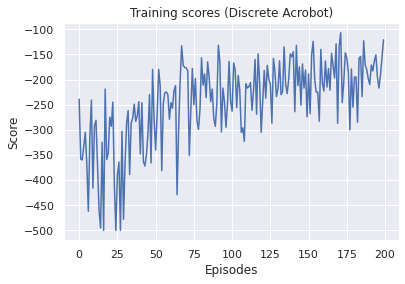


Variance of rewards: 6661.4087 



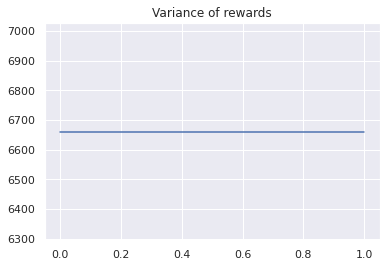

In [ ]:
env = gym.make('Acrobot-v1')
Sf = env.observation_space.shape[0]
Af = env.action_space.n
DISCOUNT = 0.9
EPOCHS = 200
LR = 0.001

policy_agent = PolicyGradientAgent(Sf, Af, cont=False)
scores = train(env, policy_agent, EPOCHS, DISCOUNT, LR, cont=False, base=False)

print()
sns.set()

plt.plot(scores)
plt.title("Training scores (Discrete Acrobot)")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.show()

print("\nVariance of rewards:", np.var(scores), "\n")
plt.plot([0, 1], np.ones(2) * np.var(scores))
plt.title("Variance of rewards")
plt.show()

We saw that discrete action space environment didn't train properly before when training on Mountain Car environment. However, when used another environment with discrete action space, there were changes in rewards over epochs. Hence, these examples show that policy gradients works well with some kinds of environment dynamics. Coming to this Acrobot environment, the rewards obtained initially are visibally less. However, over time with epochs, we can see a clear increase in the rewards with high variance. THe variance of rewards with this environment is around 6660. This high variance can also be seen in the plot. Definitely discrete environments are a perfect fit for policy gradient methods, as they work in real numbers. However, with this environment, we can see reasonable performance.

### Policy Gradient with Baseline (Discrete Mountain Car)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	Loss: -1.613 	Score: -200.000
Epoch: 2 	Loss: -2.310 	Score: -200.000
Epoch: 3 	Loss: -0.271 	Score: -200.000
Epoch: 4 	Loss: -0.176 	Score: -200.000
Epoch: 5 	Loss: 2.330 	Score: -200.000
Epoch: 6 	Loss: 0.520 	Score: -200.000
Epoch: 7 	Loss: -3.012 	Score: -200.000
Epoch: 8 	Loss: 2.832 	Score: -200.000
Epoch: 9 	Loss: -0.837 	Score: -200.000
Epoch: 10 	Loss: 1.704 	Score: -200.000
Epoch: 11 	Loss: -2.264 	Score: -200.000
Epoch: 12 	Loss: -0.921 	Score: -200.000
Epoch: 13 	Loss: -2.536 	Score: -200.000
Epoch: 14 	Loss: -2.379 	Score: -200.000
Epoch: 15 	Loss: 3.950 	Score: -200.000
Epoch: 16 	Loss: -0.948 	Score: -200.000
Epoch: 17 	Loss: -2.862 	Score: -200.000
Epoch: 18 	Loss: -2.264 	Score: -200.000
Epoch: 19 	Loss: 5.538 	Score: -200.000
Epoch: 20 	Loss: 2.926 	Score: -200.000
Epoch: 21 	Loss: 6.507 	Score: -200.000
Epoch: 22 	Loss: 6.188 	Score: -200.000
Epoch: 23 	Loss: 3.028 	Score: -200.000
Epoch: 24 	Loss: -0.343 	Score: -200.000
Epoch: 25 	Loss: 2.071 	Score: -200

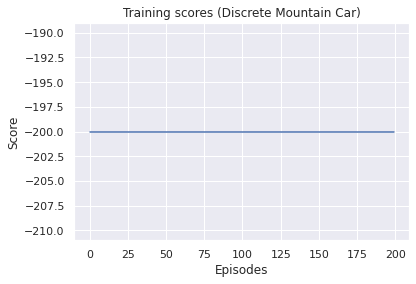


Variance of rewards: 0.0 



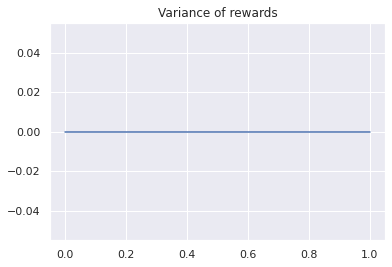

In [ ]:
env = gym.make('MountainCar-v0')
Sf = env.observation_space.shape[0]
Af = env.action_space.n
DISCOUNT = 0.9
EPOCHS = 200
LR = 0.001

policy_agent = PolicyGradientAgent(Sf, Af, cont=False)
scores = train(env, policy_agent, EPOCHS, DISCOUNT, LR, cont=False, base=True)

print()
sns.set()

plt.plot(scores)
plt.title("Training scores (Discrete Mountain Car)")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.show()

print("\nVariance of rewards:", np.var(scores), "\n")
plt.plot([0, 1], np.ones(2) * np.var(scores))
plt.title("Variance of rewards")
plt.show()

We see that the score in all epochs of the training phase is same (-200) again. Here we have used a baseline while training, which is taken as mean over discounted returns (**G.mean()**). However, as we already saw that policy gradient methods didn't work well with this environment. This shows that the optimal policy is not being learnt. This also could be a resultant of an inefficient environment. As policy gradient is mainly designed to use neural networks and operate on real numbers, it might work bad on discrete action space environments. This environment is an example of that. As the score/reward is same across all epochs, the variance of the rewards is 0.

### Policy Gradient with Baseline (Continuous Mountain Car)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 	Loss: -95.414 	Score: -124.067
Epoch: 2 	Loss: -95.127 	Score: -121.680
Epoch: 3 	Loss: -83.707 	Score: -114.051
Epoch: 4 	Loss: -98.386 	Score: -118.244
Epoch: 5 	Loss: -98.625 	Score: -109.016
Epoch: 6 	Loss: -106.559 	Score: -109.535
Epoch: 7 	Loss: -76.588 	Score: -97.993
Epoch: 8 	Loss: -90.922 	Score: -101.549
Epoch: 9 	Loss: -80.681 	Score: -95.831
Epoch: 10 	Loss: -71.915 	Score: -96.954
Epoch: 11 	Loss: -90.971 	Score: -87.280
Epoch: 12 	Loss: -70.649 	Score: -85.436
Epoch: 13 	Loss: -68.918 	Score: -87.360
Epoch: 14 	Loss: -92.269 	Score: -82.507
Epoch: 15 	Loss: -76.739 	Score: -77.675
Epoch: 16 	Loss: -65.286 	Score: -73.276
Epoch: 17 	Loss: -52.579 	Score: -66.058
Epoch: 18 	Loss: -51.925 	Score: -64.867
Epoch: 19 	Loss: -59.812 	Score: -65.246
Epoch: 20 	Loss: -78.254 	Score: -67.699
Epoch: 21 	Loss: -58.111 	Score: -61.528
Epoch: 22 	Loss: -53.286 	Score: -58.432
Epoch: 23 	Loss: -48.624 	Score: -56.183
Epoch: 24 	Loss: -49.888 	Score: -55.258
Epoch: 25 	Loss: 

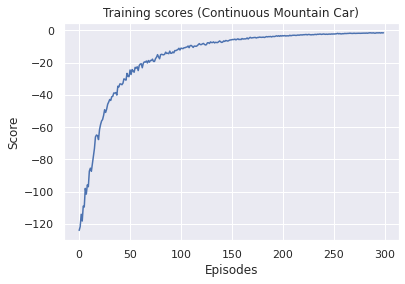


Variance of rewards: 582.89105 



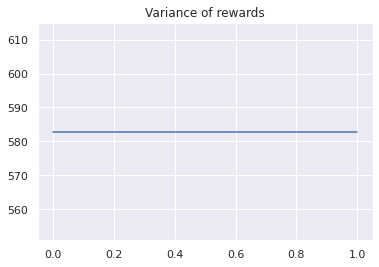

In [ ]:
env = gym.make('MountainCarContinuous-v0')
Sf = env.observation_space.shape[0]
Af = 2
DISCOUNT = 0.9
EPOCHS = 300
LR = 0.001

policy_agent = PolicyGradientAgent(Sf, Af, cont=True)
scores = train(env, policy_agent, EPOCHS, DISCOUNT, LR, cont=True, base=True)

print()
sns.set()

plt.plot(scores)
plt.title("Training scores (Continuous Mountain Car)")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.show()

print("\nVariance of rewards:", np.var(scores), "\n")
plt.plot([0, 1], np.ones(2) * np.var(scores))
plt.title("Variance of rewards")
plt.show()

Here we see the working of policy gradient approach efficiently again. The rewards vs epochs plot shows the improving nature of learnt policy. We see that in the initial epochs, the reward obtained through simulations performed is around -120. By epochs 300, the policy seems to be converging with reward of around -1.5. Giving it even more iterations can bring it closer to -1 reward. The variance however seems to be reasonable, not too large neither too small. However, we see that the variance obtained in this method is lesser than the variance of rewards obtained in previous method without baseline. The baseline used in this method is average of discounted returns (**G.mean()**). The variance of 582.89 could be because of normalized policy outputs while sampling and definitely due to adding baseline, which descreased variance by small amount if not by large value. I have used Normal distribution to sample the action, which could have resulted in smaller variance. Overall, the learning efficacy can be seen in this problem.

### Policy Gradient with Baseline (Discrete Acrobot)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	Loss: -70.654 	Score: -249.000
Epoch: 2 	Loss: -10.760 	Score: -263.000
Epoch: 3 	Loss: -12.737 	Score: -385.000
Epoch: 4 	Loss: 0.761 	Score: -354.000
Epoch: 5 	Loss: -34.445 	Score: -500.000
Epoch: 6 	Loss: -39.212 	Score: -478.000
Epoch: 7 	Loss: -35.707 	Score: -324.000
Epoch: 8 	Loss: -2.200 	Score: -314.000
Epoch: 9 	Loss: -4.268 	Score: -500.000
Epoch: 10 	Loss: -25.246 	Score: -264.000
Epoch: 11 	Loss: -17.429 	Score: -500.000
Epoch: 12 	Loss: -17.990 	Score: -298.000
Epoch: 13 	Loss: 0.508 	Score: -443.000
Epoch: 14 	Loss: -47.389 	Score: -433.000
Epoch: 15 	Loss: -57.254 	Score: -449.000
Epoch: 16 	Loss: -12.903 	Score: -347.000
Epoch: 17 	Loss: -18.589 	Score: -459.000
Epoch: 18 	Loss: -7.183 	Score: -286.000
Epoch: 19 	Loss: -3.963 	Score: -283.000
Epoch: 20 	Loss: -7.979 	Score: -276.000
Epoch: 21 	Loss: -13.306 	Score: -278.000
Epoch: 22 	Loss: -61.880 	Score: -327.000
Epoch: 23 	Loss: -25.348 	Score: -235.000
Epoch: 24 	Loss: -14.500 	Score: -273.000
Epoch: 25 

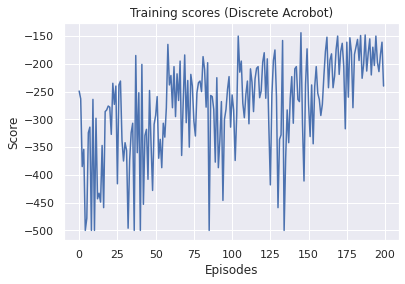


Variance of rewards: 7646.746 



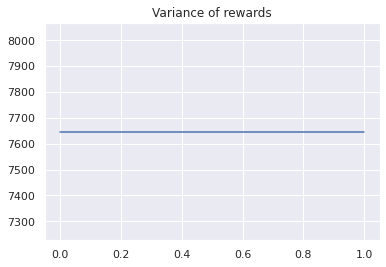

In [ ]:
env = gym.make('Acrobot-v1')
Sf = env.observation_space.shape[0]
Af = env.action_space.n
DISCOUNT = 0.9
EPOCHS = 200
LR = 0.001

policy_agent = PolicyGradientAgent(Sf, Af, cont=False)
scores = train(env, policy_agent, EPOCHS, DISCOUNT, LR, cont=False, base=True)

print()
sns.set()

plt.plot(scores)
plt.title("Training scores (Discrete Acrobot)")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.show()

print("\nVariance of rewards:", np.var(scores), "\n")
plt.plot([0, 1], np.ones(2) * np.var(scores))
plt.title("Variance of rewards")
plt.show()

We saw that discrete action space environment didn't train properly before when training on Mountain Car environment. However, when used another environment with discrete action space, there were changes in rewards over epochs. Hence, these examples show that policy gradients works well with some kinds of environment dynamics. Coming to this Acrobot environment, the rewards obtained initially are visibally less. However, over time with epochs, we can see a clear increase in the rewards with high variance. However, the inclusion of baseline should have reduced the variance of rewards over epochs, but here we see that the variance has increased. This could be again due to the discreteness of the environment. Discrete environments are not optimized for this kind of policy gradient methods, due to which there could be bad performances of these methods. The variance of rewards with this environment is around 7650 with addition of baseline. This high variance can also be seen in the plot. Definitely discrete environments are a perfect fit for policy gradient methods, as they work in real numbers. However, with this environment, we can see reasonable performance.

## Actor Critic State Dependent Baseline Model

In [ ]:
class StateBaseline(nn.Module):
    '''
    Models the state dependent baseline network

    Input
    -----
    Sf: (int) Dimension of state features
    '''

    # Initialization method
    def __init__(self, Sf):
        super(StateBaseline, self).__init__()

        self.hidden = nn.Linear(in_features=Sf, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=1)

    # Method for forward pass
    def forward(self, state_feature):
        out = self.hidden(state_feature)
        out = F.relu(out)
        out = self.out(out)

        return out

In [ ]:
def train_ac(env, policy, baseline, epochs, gamma, lr, cont):
        '''
    Function to train the policy network and state dependent network
    using actor critic method

    Input
    -----
    env:      (object)  Input environment on which the model will be trained
    policy:   (object)  Policy network which will be trained
    baseline: (object)  State dependent baseline network model
    epochs:   (int)     Number of epochs for training
    gamma:    (float)   Discount factor
    lr:       (float)   Learning rate
    cont:     (boolean) Continuous/discrete action space

    Output
    ------
    scores: (list)  List of rewards in each epoch
    '''
    
    policy_opt = torch.optim.Adam(params=policy.parameters(), lr=lr)
    baseline_opt = torch.optim.Adam(params=baseline.parameters(), lr=lr)
    scores = []

    for ep in tqdm(range(epochs)):
        S, A, R, Lp = get_episode(env, policy, cont)
        G = discounted_rewards(R, gamma)
        scores.append(torch.sum(R))
        
        state_vals = []
        for state in S:
            state_vals.append(baseline(state))

        state_vals = torch.stack(state_vals).squeeze()
        baseline_loss = F.mse_loss(state_vals, G)

        baseline_opt.zero_grad()
        baseline_loss.backward()
        baseline_opt.step()

        policy_loss = 0
        for lp, dr, sv in zip(Lp, G, state_vals):
            policy_loss += -lp * (dr - sv.item())

        policy_opt.zero_grad()
        policy_loss.backward()
        policy_opt.step()

        print("Epoch: %d \tLoss: %.3f \tScore: %.3f" % (ep+1, policy_loss.item(), scores[-1]))

    return scores

### Actor Critic (Discrete Mountain Car)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	Loss: -2072.307 	Score: -200.000
Epoch: 2 	Loss: -2086.718 	Score: -200.000
Epoch: 3 	Loss: -2081.067 	Score: -200.000
Epoch: 4 	Loss: -2079.874 	Score: -200.000
Epoch: 5 	Loss: -2078.275 	Score: -200.000
Epoch: 6 	Loss: -2068.255 	Score: -200.000
Epoch: 7 	Loss: -2084.030 	Score: -200.000
Epoch: 8 	Loss: -2072.349 	Score: -200.000
Epoch: 9 	Loss: -2040.380 	Score: -200.000
Epoch: 10 	Loss: -2047.072 	Score: -200.000
Epoch: 11 	Loss: -2034.349 	Score: -200.000
Epoch: 12 	Loss: -2050.820 	Score: -200.000
Epoch: 13 	Loss: -2034.539 	Score: -200.000
Epoch: 14 	Loss: -2017.919 	Score: -200.000
Epoch: 15 	Loss: -1999.324 	Score: -200.000
Epoch: 16 	Loss: -2013.924 	Score: -200.000
Epoch: 17 	Loss: -2008.711 	Score: -200.000
Epoch: 18 	Loss: -2011.944 	Score: -200.000
Epoch: 19 	Loss: -2017.319 	Score: -200.000
Epoch: 20 	Loss: -1989.395 	Score: -200.000
Epoch: 21 	Loss: -2004.766 	Score: -200.000
Epoch: 22 	Loss: -1997.685 	Score: -200.000
Epoch: 23 	Loss: -2003.241 	Score: -200.0

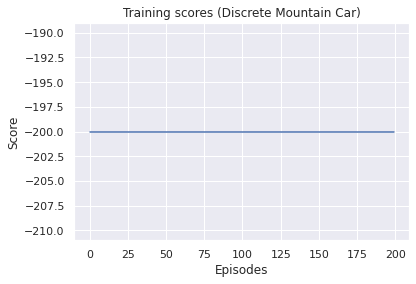


Variance of rewards: 0.0 



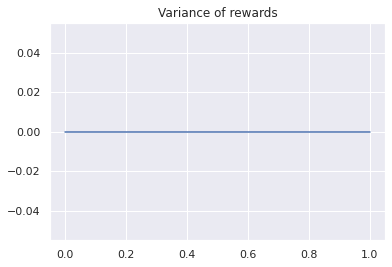

In [ ]:
env = gym.make('MountainCar-v0')
Sf = env.observation_space.shape[0]
Af = env.action_space.n
DISCOUNT = 0.9
EPOCHS = 200
LR = 0.001

policy_agent = PolicyGradientAgent(Sf, Af, cont=False)
baseline_model = StateBaseline(Sf)
scores = train_ac(env, policy_agent, baseline_model, EPOCHS, DISCOUNT, LR, cont=False)

print()
sns.set()

plt.plot(scores)
plt.title("Training scores (Discrete Mountain Car)")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.show()

print("\nVariance of rewards:", np.var(scores), "\n")
plt.plot([0, 1], np.ones(2) * np.var(scores))
plt.title("Variance of rewards")
plt.show()

We see that the score in all epochs of the training phase is same (-200) again. Here we have used a baseline while training, which is taken as a separate network which is also trained parallely with the policy network. However, as we already saw that policy gradient methods didn't work well with this environment. This shows that the optimal policy is not being learnt. This also could be a resultant of an inefficient environment. As policy gradient is mainly designed to use neural networks and operate on real numbers, it might work bad on discrete action space environments. This environment is an example of that. As the score/reward is same across all epochs, the variance of the rewards is 0.

### Actor Critic (Continuous Mountain Car)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 	Loss: -634.251 	Score: -81.954
Epoch: 2 	Loss: -536.437 	Score: -78.310
Epoch: 3 	Loss: -379.312 	Score: -70.267
Epoch: 4 	Loss: -322.487 	Score: -67.898
Epoch: 5 	Loss: -377.464 	Score: -73.456
Epoch: 6 	Loss: -306.100 	Score: -70.565
Epoch: 7 	Loss: -189.827 	Score: -63.525
Epoch: 8 	Loss: -141.261 	Score: -62.733
Epoch: 9 	Loss: -96.043 	Score: -60.454
Epoch: 10 	Loss: -68.846 	Score: -59.511
Epoch: 11 	Loss: -33.927 	Score: -57.154
Epoch: 12 	Loss: -28.432 	Score: -58.933
Epoch: 13 	Loss: 73.146 	Score: -50.782
Epoch: 14 	Loss: 88.053 	Score: -50.431
Epoch: 15 	Loss: 107.664 	Score: -47.530
Epoch: 16 	Loss: 123.342 	Score: -47.389
Epoch: 17 	Loss: 131.835 	Score: -46.125
Epoch: 18 	Loss: 159.706 	Score: -41.929
Epoch: 19 	Loss: 127.867 	Score: -45.276
Epoch: 20 	Loss: 173.190 	Score: -41.014
Epoch: 21 	Loss: 157.491 	Score: -41.537
Epoch: 22 	Loss: 145.648 	Score: -40.133
Epoch: 23 	Loss: 176.505 	Score: -35.592
Epoch: 24 	Loss: 127.823 	Score: -39.288
Epoch: 25 	Loss: 99

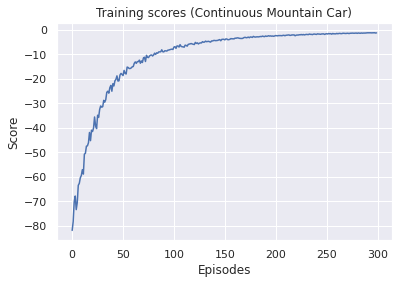


Variance of rewards: 240.70393 



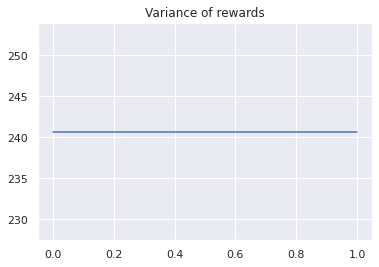

In [ ]:
env = gym.make('MountainCarContinuous-v0')
Sf = env.observation_space.shape[0]
Af = 2
DISCOUNT = 0.9
EPOCHS = 300
LR = 0.001

policy_agent = PolicyGradientAgent(Sf, Af, cont=True)
baseline_model = StateBaseline(Sf)
scores = train_ac(env, policy_agent, baseline_model, EPOCHS, DISCOUNT, LR, cont=True)

print()
sns.set()

plt.plot(scores)
plt.title("Training scores (Continuous Mountain Car)")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.show()

print("\nVariance of rewards:", np.var(scores), "\n")
plt.plot([0, 1], np.ones(2) * np.var(scores))
plt.title("Variance of rewards")
plt.show()

We see from the above plot that the learning is optimal in this environment with a separate baseline network. Baseline is state value which is learnt from the state features using a separate network which is also trained parallely with the policy network. The variance should be decreased even more in this case than the 2nd case with constant baseline. And we see that reduction in variace. The variance in older cases were around 600 and 550. Here we can see that the variance is around 250, which is a great reduction in variance of rewards over eopchs and hence shows the efficacy of this methods of Actor - Critic, where the baseline (state value) is also learnt over epochs. Hece, this methods best for this continuous environment, which can be seen from the above plots.

### Actor Critic (Discrete Acrobot)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	Loss: -2869.902 	Score: -280.000
Epoch: 2 	Loss: -4266.659 	Score: -416.000
Epoch: 3 	Loss: -4388.112 	Score: -429.000
Epoch: 4 	Loss: -2640.163 	Score: -259.000
Epoch: 5 	Loss: -3454.739 	Score: -334.000
Epoch: 6 	Loss: -5292.443 	Score: -500.000
Epoch: 7 	Loss: -4313.752 	Score: -418.000
Epoch: 8 	Loss: -2831.160 	Score: -287.000
Epoch: 9 	Loss: -3268.563 	Score: -319.000
Epoch: 10 	Loss: -5184.817 	Score: -500.000
Epoch: 11 	Loss: -4025.034 	Score: -398.000
Epoch: 12 	Loss: -5158.243 	Score: -500.000
Epoch: 13 	Loss: -5016.043 	Score: -500.000
Epoch: 14 	Loss: -5218.641 	Score: -500.000
Epoch: 15 	Loss: -4376.144 	Score: -436.000
Epoch: 16 	Loss: -4227.786 	Score: -422.000
Epoch: 17 	Loss: -5243.099 	Score: -500.000
Epoch: 18 	Loss: -5018.993 	Score: -500.000
Epoch: 19 	Loss: -5052.578 	Score: -500.000
Epoch: 20 	Loss: -5051.421 	Score: -500.000
Epoch: 21 	Loss: -4792.232 	Score: -492.000
Epoch: 22 	Loss: -4915.602 	Score: -500.000
Epoch: 23 	Loss: -4909.979 	Score: -500.0

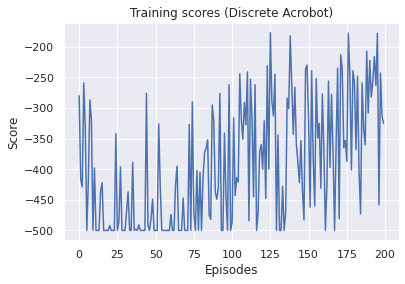


Variance of rewards: 9745.538 



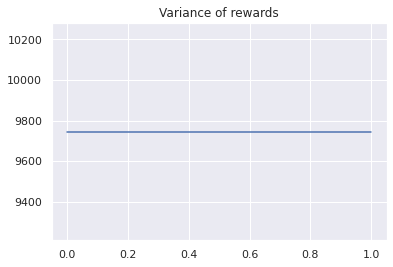

In [ ]:
env = gym.make('Acrobot-v1')
Sf = env.observation_space.shape[0]
Af = env.action_space.n
DISCOUNT = 0.9
EPOCHS = 200
LR = 0.001

policy_agent = PolicyGradientAgent(Sf, Af, cont=False)
baseline_model = StateBaseline(Sf)
scores = train_ac(env, policy_agent, baseline_model, EPOCHS, DISCOUNT, LR, cont=False)

print()
sns.set()

plt.plot(scores)
plt.title("Training scores (Discrete Acrobot)")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.show()

print("\nVariance of rewards:", np.var(scores), "\n")
plt.plot([0, 1], np.ones(2) * np.var(scores))
plt.title("Variance of rewards")
plt.show()

We saw that discrete action space environment didn't train properly before when training on Mountain Car environment. However, when used another environment with discrete action space, there were changes in rewards over epochs. Hence, these examples show that policy gradients works well with some kinds of environment dynamics. Coming to this Acrobot environment, the rewards obtained initially are visibally less. However, over time with epochs, we can see a clear increase in the rewards with high variance. However, the inclusion of baseline should have reduced the variance of rewards over epochs, but here we see that the variance has increased. Even after using actor-critic method which optimises the baseline learnt over epochs, the variance increases. This could be again due to the discreteness of the environment. Discrete environments are not optimized for this kind of policy gradient methods, due to which there could be bad performances of these methods. The variance of rewards with this environment is around 7650 with addition of baseline. This high variance can also be seen in the plot. Definitely discrete environments are a perfect fit for policy gradient methods, as they work in real numbers. However, with this environment, we can see reasonable performance.

### Gaussian policy (Continuous Mountain Car)

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Epoch: 1 	Loss: -1209.724 	Score: -86.330
Epoch: 2 	Loss: -1329.313 	Score: -92.607
Epoch: 3 	Loss: -1300.320 	Score: -90.676
Epoch: 4 	Loss: -1185.829 	Score: -84.656
Epoch: 5 	Loss: -1137.254 	Score: -81.798
Epoch: 6 	Loss: -1159.354 	Score: -82.813
Epoch: 7 	Loss: -1121.656 	Score: -80.708
Epoch: 8 	Loss: -1045.992 	Score: -75.989
Epoch: 9 	Loss: -934.991 	Score: -70.890
Epoch: 10 	Loss: -864.358 	Score: -67.211
Epoch: 11 	Loss: -939.380 	Score: -70.290
Epoch: 12 	Loss: -900.695 	Score: -68.754
Epoch: 13 	Loss: -911.313 	Score: -69.348
Epoch: 14 	Loss: -801.314 	Score: -63.129
Epoch: 15 	Loss: -876.588 	Score: -66.916
Epoch: 16 	Loss: -769.077 	Score: -61.161
Epoch: 17 	Loss: -710.586 	Score: -57.983
Epoch: 18 	Loss: -783.932 	Score: -61.557
Epoch: 19 	Loss: -765.204 	Score: -59.659
Epoch: 20 	Loss: -658.532 	Score: -54.722
Epoch: 21 	Loss: -702.687 	Score: -57.181
Epoch: 22 	Loss: -656.067 	Score: -53.847
Epoch: 23 	Loss: -703.932 	Score: -57.302
Epoch: 24 	Loss: -648.746 	Score: -

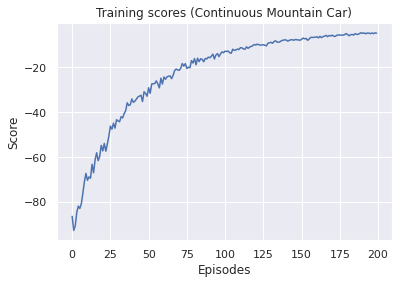


Variance of rewards: 439.16562 



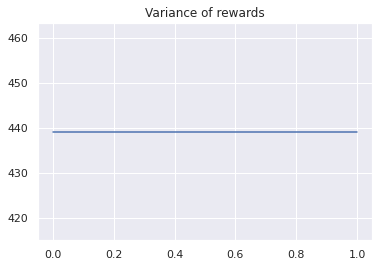

In [7]:
env = gym.make('MountainCarContinuous-v0')
Sf = env.observation_space.shape[0]
Af = 2
DISCOUNT = 0.9
EPOCHS = 200
LR = 0.001

policy_agent = PolicyGradientAgent(Sf, Af, cont=True)
scores = train(env, policy_agent, EPOCHS, DISCOUNT, LR, cont=True, base=False)

print()
sns.set()

plt.plot(scores)
plt.title("Training scores (Continuous Mountain Car)")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.show()

print("\nVariance of rewards:", np.var(scores), "\n")
plt.plot([0, 1], np.ones(2) * np.var(scores))
plt.title("Variance of rewards")
plt.show()

For this part, we can use only continuous enviroments, because the gaussian policy can be learnt over only continuous environments. This is similar to vanilla policy gradient without baseline. Because I have used gaussian policy before also. We can see that the variance is also almost same as before (around 450). We can see that tis gaussian oplicy trained with policy gradient method does good, especially in continuous space.

On the whole, we saw that the optimality and efficacy of policy learnt can be seen in the continuous action space environment (MountainCarContinuous) with actor-critic method. All three methods did well, bu thowever, actor-critic has less variance in rewards, because it learns the baselin also.

But rest two environents *discrete action spaces) didn't do well, because of their discreteness of the action spaces. Hence, we can infer that these policy based gradient methods are not optimized for discrete space environments. However, we see that in 1 environment (Acrobot), the learning could be infered, but with huge variance.

### Credits for model architectures and processing codes

Author: **Cheng Xi Tsou**\
GitHub Link: https://github.com/chengxi600/RLStuff
